In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from typing import Optional
# This Class ignores some MOE components in the original model for testing purposes


@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 4
    n_heads: int = 8  # number of heads for the Q
    n_kv_heads: Optional[int] = None  # number of heads for the K and V
    vocab_size: int = 1000
    multiple_of: int = 256  # feedforward dimension must be multiple of this
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5
    device: str = None
    # for KV Cache
    max_batch_size: int = 32
    max_seq_len: int = 512


def precompute_freqs_pos_frequencis(head_dim: int, seq_len: int, device: str, theta: float = 10000.0) -> torch.Tensor:
    assert head_dim % 2 == 0, "head_dim must be even as proposed in https://arxiv.org/pdf/2104.09864"
    # theta parameter = a sequence according to the paper
    # theta_i = 10000^(-2(i-1)/dim) for i in range(1, dim / 2 + 1)
    # shape (both theta_denominator and theta): (head_dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)
    # build the "m" in the paper (aka the positions)
    # shape: (seq_len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product (for all possible combinations of the two)
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # Compute the complex number polar form: c = R * exp(m * theta) w/ R = 1
    # (seq_len, head_dim / 2) -> (seq_len, head_dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex


class Transformer(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        assert args.vocab_size > 0, "vocab size should be set"
        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        # input embedding
        self.tok_embeddings = nn.Embedding(args.vocab_size, args.dim)
        # each transformer layers in (Nx part) of the model, total self.n_layers blocks
        self.layers = nn.ModuleList([TransformerBlock(args=args) for _ in range(args.n_layers)])
        # RMS Normalization (better than LayerNorm) - used in Llama and Mistral
        self.norm = RMSNorm(args.dim, eps=args.norm_eps)    # eps for numerical stability never divided by 0
        # output layer
        self.output = nn.Linear(args.dim, args.vocab_size, bias=False)
        # precomputed frequencies for ROPE positional encoding (https://arxiv.org/pdf/2104.09864)
        # Shapes: (max_seq_len * 2, head_dim / 2)
        self.freqs_complex = precompute_freqs_pos_frequencis(   # to precompute the sin and cos in the paper
            self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device
        )

    def forward(self, tokens: torch.Tensor, start_pos: int) -> torch.Tensor:
        """
        note that with the KV Cache, only need the latest tokens, no need all tokens: info about previous tokens are saved in the cache
        NOTE: this is only for inference, not training (in training there's no KV cache)
        """
        # (B, Seq_len)
        batch_size, seq_len = tokens.shape
        assert seq_len == 1, "One token at a time at inference time"

        # (B, Seq_len) -> (B, Seq_len, dim)
        h = self.tok_embeddings(tokens)

        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]

        # Apply precomputed frequencies to the encoding layers for positional encoding
        for layer in self.layers:
            h = layer(h, freqs_complex, start_pos, None)    # these are the Nx TransformerBlock layers

        # Apply RMS Normalization after all layers
        h = self.norm(h)

        # Output layer
        output = self.output(h)
        return output

In [20]:
args = ModelArgs()

In [21]:
print("Max_seq_len:", args.max_seq_len)
print("Head_dim:", args.dim // args.n_heads)
print("Freqs_complex shape:",   # should be (max_seq_len * 2, head_dim / 2)
      precompute_freqs_pos_frequencis(args.dim // args.n_heads, args.max_seq_len * 2, args.device).shape)

Max_seq_len: 512
Head_dim: 16
Freqs_complex shape: torch.Size([1024, 8])


In [24]:
tensor = torch.zeros((12, 4))
tensor.shape

torch.Size([12, 4])

In [27]:
tensor.unsqueeze(0).shape

torch.Size([1, 12, 4])

In [28]:
tensor.unsqueeze(0).unsqueeze(2).shape

torch.Size([1, 12, 1, 4])

In [29]:
import torch

# Example input tensor (B=batch_size, seq_len=sequence_length, H=number_of_heads, head_dim=dimension_per_head)
x = torch.randn(2, 5, 3, 4)

# Example frequencies tensor (complex numbers)
freqs_complex = torch.randn(5, 2)  # Assuming 5 frequencies with real and imaginary parts

# Step 1: Reshaping the input tensor into complex numbers
x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

# Step 2: Expanding the frequencies tensor to match the shape of the input tensor
freqs_complex_expanded = freqs_complex.unsqueeze(0).unsqueeze(2)

# Step 3: Element-wise multiplication of complex tensors
x_rotated = x_complex * freqs_complex_expanded

# Step 4: Converting complex tensor to real tensor
x_real = torch.view_as_real(x_rotated)

# Step 5: Flattening the tensor
x_flattened = x_real.reshape(*x.shape)

# Printing shapes to visualize the transformations
print("Input tensor shape:", x.shape)
print("Complex tensor shape:", x_complex.shape)
print("Expanded frequencies tensor shape:", freqs_complex_expanded.shape)
print("Rotated complex tensor shape:", x_rotated.shape)
print("Real tensor shape:", x_real.shape)
print("Flattened tensor shape:", x_flattened.shape)

Input tensor shape: torch.Size([2, 5, 3, 4])
Complex tensor shape: torch.Size([2, 5, 3, 2])
Expanded frequencies tensor shape: torch.Size([1, 5, 1, 2])
Rotated complex tensor shape: torch.Size([2, 5, 3, 2])
Real tensor shape: torch.Size([2, 5, 3, 2, 2])
Flattened tensor shape: torch.Size([2, 5, 3, 4])


In [32]:
print(x)

tensor([[[[ 4.0634e-01,  6.5052e-01, -4.0613e-01, -1.6863e+00],
          [-1.6818e-01,  5.2302e-01,  4.5995e-02,  7.1850e-01],
          [ 1.3306e+00,  8.8058e-01,  1.1169e+00, -1.4236e+00]],

         [[-1.7608e+00,  6.0484e-01, -2.2931e-01,  1.3687e-01],
          [-1.3313e+00,  8.4889e-01, -8.2096e-01, -2.0487e+00],
          [-1.1707e+00,  3.7725e-01,  3.5198e-01, -1.2474e+00]],

         [[ 2.2884e+00,  2.3790e-01,  6.6371e-01,  1.4763e-01],
          [ 1.1743e-01, -1.0336e-01,  7.8413e-02,  2.1786e-02],
          [ 9.4651e-01,  3.9243e-01, -1.0347e+00,  2.4265e+00]],

         [[ 7.2945e-01, -1.3962e+00, -2.6405e-01, -5.2072e-01],
          [-6.5911e-01,  2.2563e-02, -8.1039e-01, -1.0036e+00],
          [-1.2535e+00, -1.9269e-01,  1.4061e-01,  8.7562e-01]],

         [[-3.5871e-01, -2.0886e+00, -5.3053e-01,  1.2392e+00],
          [-1.9687e+00, -4.9926e-01, -5.2410e-01,  5.0675e-02],
          [-7.1429e-01, -6.9997e-01, -1.2316e+00, -5.7057e-01]]],


        [[[-1.2621e+00,  3.5

In [33]:
print(x_complex)

tensor([[[[ 0.4063+6.5052e-01j, -0.4061-1.6863e+00j],
          [-0.1682+5.2302e-01j,  0.0460+7.1850e-01j],
          [ 1.3306+8.8058e-01j,  1.1169-1.4236e+00j]],

         [[-1.7608+6.0484e-01j, -0.2293+1.3687e-01j],
          [-1.3313+8.4889e-01j, -0.8210-2.0487e+00j],
          [-1.1707+3.7725e-01j,  0.3520-1.2474e+00j]],

         [[ 2.2884+2.3790e-01j,  0.6637+1.4763e-01j],
          [ 0.1174-1.0336e-01j,  0.0784+2.1786e-02j],
          [ 0.9465+3.9243e-01j, -1.0347+2.4265e+00j]],

         [[ 0.7295-1.3962e+00j, -0.2640-5.2072e-01j],
          [-0.6591+2.2563e-02j, -0.8104-1.0036e+00j],
          [-1.2535-1.9269e-01j,  0.1406+8.7562e-01j]],

         [[-0.3587-2.0886e+00j, -0.5305+1.2392e+00j],
          [-1.9687-4.9926e-01j, -0.5241+5.0675e-02j],
          [-0.7143-6.9997e-01j, -1.2316-5.7057e-01j]]],


        [[[-1.2621+3.5530e-01j,  0.0989-5.7314e-01j],
          [ 0.5756+4.5370e-01j, -0.5748+1.0765e-01j],
          [ 0.1130-3.6985e-01j,  0.6127+1.0720e-02j]],

         [[-1.

In [38]:
input_tensor = torch.tensor([
    [[1, 2], [3, 4]],
    [[5, 6], [7, 8]],
    [[9, 10], [11, 12]]
])

# Define the Dim vector
Dim = torch.tensor([2, 2])
Expanded_Dim = Dim.unsqueeze(0).unsqueeze(0)

# Perform element-wise multiplication
assert(input_tensor * Expanded_Dim == input_tensor * Dim).all()

In [46]:
import torch

# Define the input tensor (B, Seq_Len, Dim)
input_tensor = torch.tensor([
    [[1, 2], [3, 4]],
    [[5, 6], [7, 8]],
    [[9, 10], [11, 12]]
])

# Define the one-dimensional tensor Seq_Len
Seq_Len = torch.tensor([2, 3, 4])  # Example values for Seq_Len

# Reshape or expand Seq_Len to match the shape of the input tensor
# You can choose one of the following approaches:

# Approach 1: Reshape Seq_Len to have the same number of dimensions as the input tensor
reshaped_Seq_Len = Seq_Len.unsqueeze(-1).unsqueeze(-1)  # Reshape to (Seq_Len, 1, 1)

# Approach 2: Expand Seq_Len to match the shape of the input tensor
expanded_Seq_Len = Seq_Len.unsqueeze(0).unsqueeze(0)  # Expand to (1, 1, Seq_Len)

# Perform element-wise multiplication between the reshaped or expanded Seq_Len and the input tensor
result_tensor = input_tensor * reshaped_Seq_Len  # or expanded_Seq_Len

print("Input tensor shape:", input_tensor.shape)
print("Reshaped Seq_Len shape:", reshaped_Seq_Len.shape)
print("Expanded Seq_Len shape:", expanded_Seq_Len.shape)
print("Result tensor shape:", result_tensor.shape)
print(result_tensor) 

Input tensor shape: torch.Size([3, 2, 2])
Reshaped Seq_Len shape: torch.Size([3, 1, 1])
Expanded Seq_Len shape: torch.Size([1, 1, 3])
Result tensor shape: torch.Size([3, 2, 2])
tensor([[[ 2,  4],
         [ 6,  8]],

        [[15, 18],
         [21, 24]],

        [[36, 40],
         [44, 48]]])


In [4]:
encoded_prompts = [[1, 2, 3, 1, 2, 5, 7], [4, 5, 6, 9, 4, 5, 6, 9]]
generated_sequences = generate(
    encoded_prompts=encoded_prompts,
    model=transformer,
    max_tokens=20,
    temperature=0.8,
    eos_id=None  # Replace with an appropriate eos_id if available
)

reach here 0 0 


AttributeError: 'BufferCache' object has no attribute 'mask'

In [5]:
# input_ids need to be a tensor of shape torch.Size([args.dim * args.max_batch_size])
# each entry need to be within range [0, args.vocab_size - 1]
input = torch.tensor([args.vocab_size - 1] * (args.dim * args.max_batch_size))
seqlens = [args.dim] * args.max_batch_size  # Assuming all sequences are of maximum length for simplicity
output = transformer(input, seqlens)

hshape torch.Size([2048, 128])


In [6]:
input.shape

torch.Size([2048])

In [7]:
output.shape

torch.Size([2048, 100])

In [8]:
pred = sample(output, temperature=0.8, top_p=0.9)

In [9]:
pred.shape

torch.Size([2048])

In [27]:
from graphviz import Digraph

def visualize_token_flow(tokens, attention_matrix):
    dot = Digraph(comment='Token Flow')

    # Adding nodes for each token
    for i, token in enumerate(tokens):
        dot.node(str(i), token)

    # Adding edges based on attention scores
    # Assuming attention_matrix is a square matrix with dimensions (len(tokens), len(tokens))
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            # Add edges with labels of attention scores
            # Thresholding attention to avoid clutter, only show significant attention flows
            if attention_matrix[i][j] > 0.1:  # threshold can be adjusted
                dot.edge(str(j), str(i), label=f'{attention_matrix[i][j]:.2f}')

    print(dot.source)  # optionally print the DOT source code for debugging
    dot.render('token_flow', format='png', cleanup=True)
    return dot

// Token Flow
digraph {
	0 [label=Hello]
	1 [label=world]
	2 [label=this]
	3 [label=is]
	4 [label=a]
	5 [label=test]
	1 -> 0 [label=0.20]
	1 -> 1 [label=0.30]
	2 -> 2 [label=0.50]
	3 -> 2 [label=0.20]
	2 -> 3 [label=0.20]
	3 -> 3 [label=0.60]
	4 -> 4 [label=0.60]
	5 -> 5 [label=0.70]
}


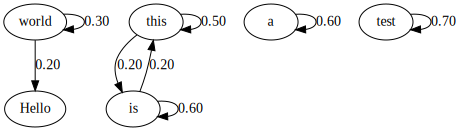

In [40]:
tokens = ['Hello', 'world', 'this', 'is', 'a', 'test']
# Example attention matrix (normally this should be output from a model)
attention_matrix = [
    [0.1, 0.2, 0, 0, 0, 0],
    [0.1, 0.3, 0, 0, 0, 0],
    [0, 0, 0.5, 0.2, 0.1, 0.1],
    [0, 0, 0.2, 0.6, 0.1, 0],
    [0, 0, 0.1, 0.1, 0.6, 0.1],
    [0, 0, 0, 0, 0.1, 0.7]
]
visualize_token_flow(tokens, attention_matrix)